# English language level classification

The objective of this work is to build a system to classify the Level of writing samples by English language learners, using a dataset gathered from users.


Each Level is comprised of multiple units. Learners progress in linear order from one Level to the next, although within a Level, they may jump around from one unit to another. Typically, one of the last units in a Level is the “written task”, in which the learners write freely on a given topic

# Imports

We will be using this script to import everything we need:

In [222]:
# Model and tools imports
from text_classifier import *

# Reload module automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Plotting imports

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

_ = sns.set(style="whitegrid", rc={"figure.figsize": (12, 6),
#                                "legend.fontsize": "large",
                               "axes.titlesize": "large",
                               "xtick.labelsize": "large",
                               "ytick.labelsize": "large",
                               }),

# Loading data

Parsed xml data as pandas dataframe and saved id as csv for faster processing. Used below function

In [2]:
def get_csv_from_xml():
    """
    Function to transform xml data to csv so faster processing.
    WARNING: takes about 30 mins to run!
    NOTES:
        - manually removed the header/meta data section of the xml and saved it as EFWritingData_nohead_replaced.xml
        - renamed the <text> to <userinput> using following command:
            sed -i '' -e 's/text>/userinput>/g' EFWritingData_nohead_replaced.xml
    :return: pandas df saved as csv
    """

    from bs4 import BeautifulSoup

    with open("EFWritingData_nohead_replaced.xml") as fp:
        soup = BeautifulSoup(fp, 'xml')

    ll = soup.find_all('writing')
    entries = []

    for w in ll:
        entries.append(
            {'writing_id': w['id'],
             'writing_level': w['level'],
             'writing_unit': w['unit'],
             'topic_id': w.topic['id'],
             'topic_text': w.topic.get_text(),
             'date': w.date.get_text(),
             'grade': w.grade.get_text(),
             'text': w.userinput.get_text()})

    df = pd.DataFrame(entries)
    df.to_csv('EFWritingData_parsed.csv')

    return df

The dataframe from the csv then looks like this:

In [5]:
start_time = time.time()

# Read data
df = pd.read_csv('data/EFWritingData_parsed.csv')

# Rename index column
df = df.rename(columns={'Unnamed: 0': 'idx'})

#  Convert string date to datetime
df['date'] = pd.to_datetime(df['date'])

print_runtime(start_time)

df.head()

Run time: 0h:0m:10s


,idx,date,grade,text,topic_id,topic_text,writing_id,writing_level,writing_unit
0,0,2011-03-20 12:44:16.790,90,"\n After some time, the affection between...",41,Writing a movie plot,1,6,1
1,1,2011-03-26 09:31:35.133,90,\n An e-ticket is a provement that you bo...,42,Filling in an arrival card,2,6,2
2,2,2011-04-03 04:16:16.137,86,\n From:xxx@1234.com To:Herman xxx@1234.c...,43,Creating an office dress code,3,6,3
3,3,2011-03-23 23:53:12.710,87,"\n Hi Anna ,How are you . My name's Jayla...",1,Introducing yourself by email,4,1,1
4,4,2011-03-25 03:13:50.393,95,"\n Dear Ms Thomas, There are thirty pens ...",2,Taking inventory in the office,5,1,2


In [6]:
df.shape

(1180309, 9)

We have ~ 1.2m records, which is large

## Data quality checks

Now let's do some basic data quality checks to ensure the suitability of the data for classification.

* Looking at the head and tail of the df, it seems there was a filter applied to the data as the last writing_id (1,211,602) > than the last index id (1,180,308)
* Also the data doesn't seem to be sorted by date, but by writing_id

#### Uniformly distributed across the rows?

Check data uniformly distributed across the rows, i.e. before spliting into train and test or reducing the size for testing, just want to ensure there's no bias in the sample:

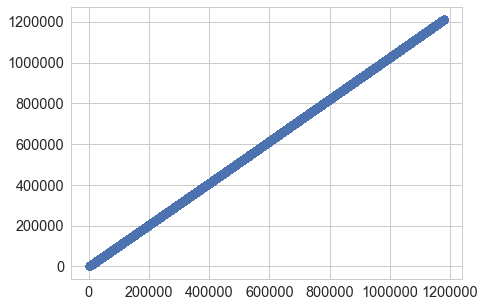

In [9]:
plt.figure(figsize=(7, 5))
plt.scatter(df['idx'], df['writing_id'])

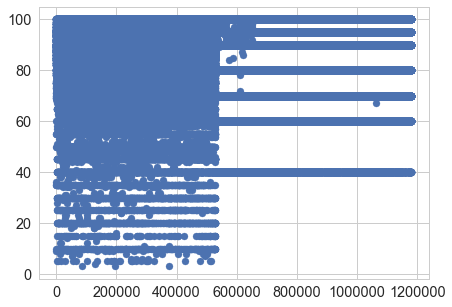

In [10]:
plt.figure(figsize=(7, 5))
plt.scatter(df['idx'], df['grade'])

Clearly there is something strange after the ~500m'th row

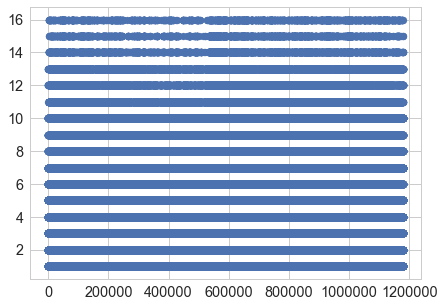

In [11]:
plt.figure(figsize=(7, 5))
plt.scatter(df['idx'], df['writing_level'])

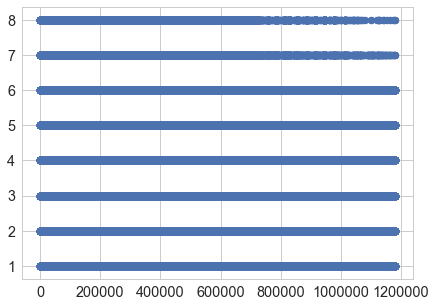

In [12]:
plt.figure(figsize=(7, 5))
plt.scatter(df['idx'], df['writing_unit'])

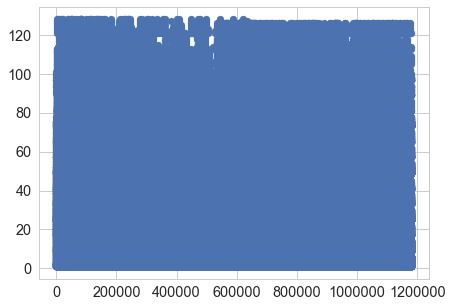

In [13]:
plt.figure(figsize=(7, 5))
plt.scatter(df['idx'], df['topic_id'])

#### Distribution wrt to time

Check data uniformly distributed across the rows, i.e. before spliting into train and test or reducing the size for testing, just want to ensure there's no bias in the sample:

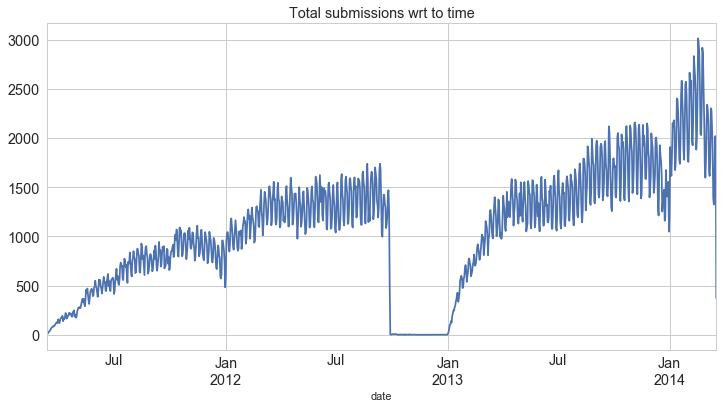

In [19]:
temp = df.copy()
temp.index = temp.date
temp = temp.drop('date', axis=1)
temp['writing_level'].resample('D').count().plot()
plt.title('Total submissions wrt to time')

#### Missing values

In [22]:
df.isnull().sum()

idx              0
date             0
grade            0
text             0
topic_id         0
topic_text       0
writing_id       0
writing_level    0
writing_unit     0
dtype: int64

#### Class imbalance on target?

In this dataset, the target column is **`writing_level`**. So we need to check that the data is a balanced sample wrt to the target label i.e. we want to have enough samples to predict each level.

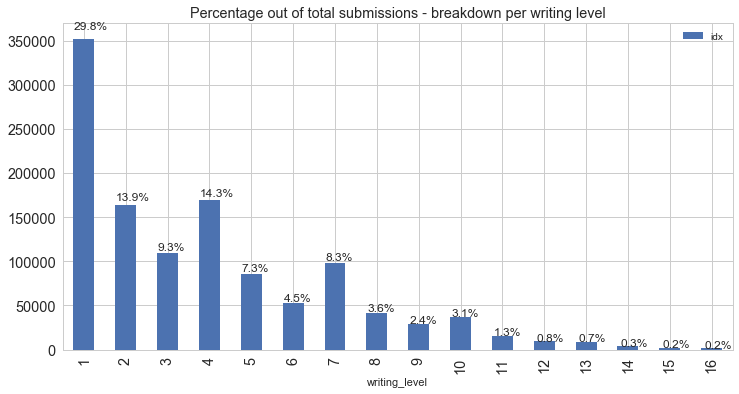

In [63]:
temp = df[['idx', 'writing_level']].groupby('writing_level').count()

ax = temp.plot(kind='bar')
for p in ax.patches:
    p_height = p.get_height()
    pct = (p_height / df.shape[0]) * 100
    ax.annotate('{:.1f}%'.format(pct), (p.get_x() * 1.005, p_height * 1.030))

plt.title('Percentage out of total submissions - breakdown per writing level')

#### DQ conclusions

* Data seems uniformly distributed wrt the sorting variable (`writing_id`) except for `grade` where this seems biased after row ~500k. <span style="color:red"> For this reason it would make sense to only use data up to this point for training </span>


* Gradual growth in number of submissions over time seems to indicate a new product was launched in mid-2011, which started collecting data but then it seems this stopped at the end of 2012 (where total submissions dropped). Data collection started again in Jan'13, with a gradual growth again. <span style="color:red"> This issue will be ignored for now but suggest to investigate impact of this on data</span>


* Very good that we have no missing values so no need to impute or handle these


* There's a large imbalance in the data wrt to the levels - most texts (~30%) are for level 1, with the highest levels having very few samples to train. <span style="color:red"> This means our model will not be good enough to predict across all levels, especially the higher levels. This effect will be worsedned when splitting into train and test</span>

# Data exploration

Now we move to the exploratory analysis of the original data before building any features. To process plots faster and reduce a potential bias from grades (see above), we will work only with the first 500k rows of the data (note this is not yet splitting by train and test).

In [7]:
# Take only first 500k rows (roughly 40% of data)
df = df.iloc[:500000, :]
df.shape

(500000, 9)

#### Relationship between levels, units and topics

In [153]:
cols = ['writing_level', 'writing_unit', 'topic_id']
temp = df[cols + ['idx']].groupby(cols).count()
temp

idx
writing_level writing_unit topic_id       
1             1            1         36075
              2            2         23020
              3            3         20709
              4            4         16274
              5            5         15095
              6            6         13005
              7            7         12574
              8            8          9446
2             1            9         11775
              2            10         9927
              3            11         9087
              4            12         7513
              5            13         7754
              6            14         7169
              7            15         7098
              8            16         6351
3             1            17         8750
              2            18         6950
              3            19         6789
              4            20         5840
              5            21         5714
              6            22         5411
              7            23         5130
              8            24         4739
4             1            25        18978
              2            26        14115
              3            27        10508
              4            28         8755
              5            29         8531
              6            30         7602
...                                    ...
13            3            99          437
              4            100         402
              5            101         344
              6            102         203
              7            103         152
              8            104         245
14            1            105         224
              2            106         183
              3            107         163
              4            108         151
              5            109         136
              6            110         129
              7            111         117
              8            112         113
15            1            113         129
              2            114         116
              3            115          72
              4            116          58
              5            117          77
              6            118          78
              7            119          76
              8            120          70
16            1            121         123
              2            122         100
              3            123          62
              4            124          61
              5            125          64
              6            126          47
              7            127          58
              8            128          57

[128 rows x 1 columns]

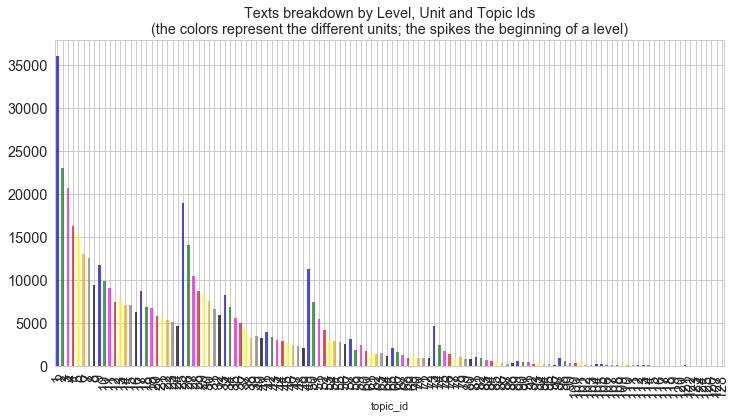

In [154]:
temp = temp.reset_index()
pivot = temp.pivot(index='topic_id', columns='writing_unit', values='idx').fillna(0)


colors = ['blue', 'green', 'magenta', 'red', 'yellow', 'orange', 'grey', 'black'] * 20
for level in pivot:
    pivot[level].plot(kind='bar', alpha=0.7, color=colors[level-1])
    
plt.title('Texts breakdown by Level, Unit and Topic Ids\n(the colors represent the different units; the spikes the beginning of a level)')

Some observations from the above:

* There seems to be always 8 units per level
* The topic id is a unique integer reflecting both the level and unit
* Most text submissions are for the first units of each level

### Distributions

In [158]:
df[['grade', 'writing_level', 'writing_unit']].describe()

,grade,writing_level,writing_unit
count,500000.000000,500000.000000,500000.000000
mean,90.296736,3.795398,3.735646
std,8.844047,2.866613,2.290302
min,3.000000,1.000000,1.000000
25%,88.000000,1.000000,2.000000
50%,92.000000,3.000000,3.000000
75%,96.000000,5.000000,6.000000
max,100.000000,16.000000,8.000000


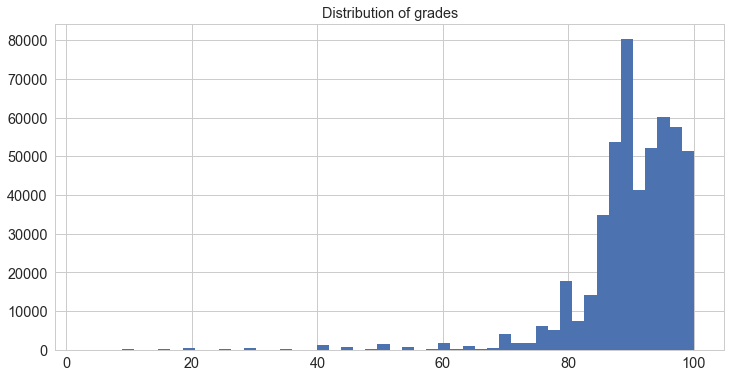

In [160]:
df['grade'].hist(bins=50)
plt.title('Distribution of grades')

* The grade distribution is skewed to the left (long tail on the left), and the most common grade seems to be 90%, with most of the students scoring between 80-100%

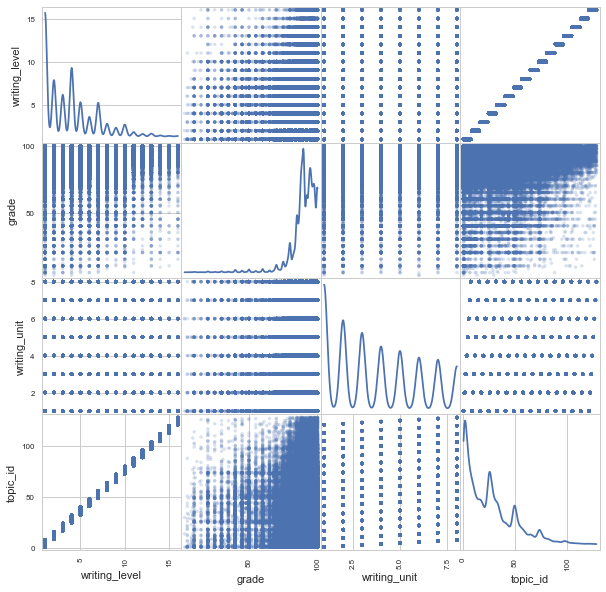

In [169]:
from pandas.plotting import scatter_matrix

_ = scatter_matrix(df[['writing_level', 'grade', 'writing_unit', 'topic_id']],
               alpha=0.2, figsize=(10, 10),  diagonal='kde')

* `topic_id` highly correlated to `writing_level`
* Grades tend to be higher for higher levels and more spreaded for lower levels

### Relationships wrt time

In [172]:
temp = df[['date', 'grade', 'topic_id', 'writing_level', 'writing_unit']]
temp.index = temp.date
temp = temp.drop('date', axis=1)

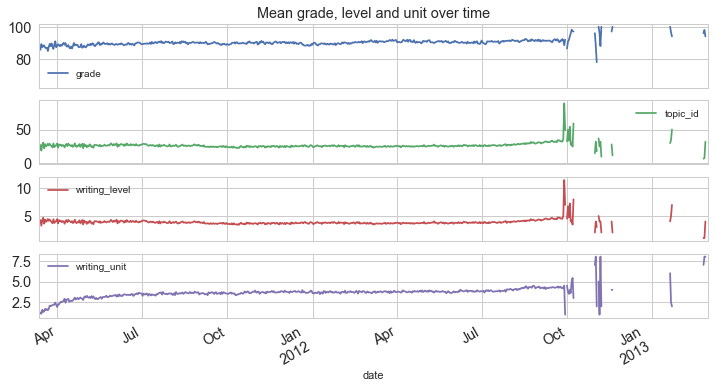

In [173]:
ax = temp.resample('D').mean().plot(subplots=True)
ax[0].set_title('Mean grade, level and unit over time')

* This plot doesn't show any seasonal patterns wrt to the mean over the days

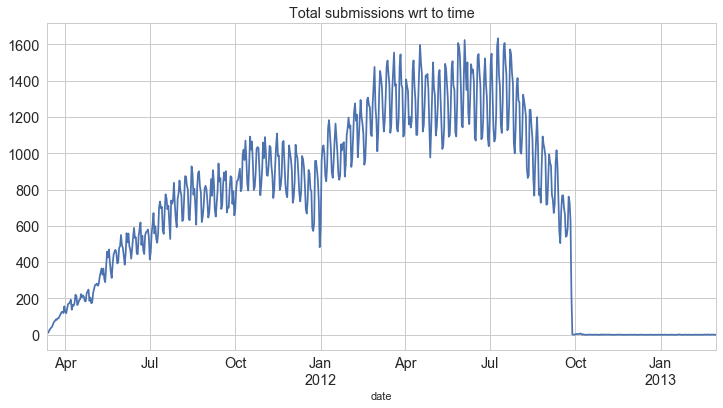

In [174]:
temp['writing_level'].resample('D').count().plot()
plt.title('Total submissions wrt to time')

* Again we see missing dates related to the DQ issue discussed before
* The plot shows weekly and monthly seasonal patterns wrt total submissions from students. This is expected due to weekends and holidays

In [175]:
temp.head()

,grade,topic_id,writing_level,writing_unit
date,,,,
2011-03-20 12:44:16.790,90,41,6,1
2011-03-26 09:31:35.133,90,42,6,2
2011-04-03 04:16:16.137,86,43,6,3
2011-03-23 23:53:12.710,87,1,1,1
2011-03-25 03:13:50.393,95,2,1,2


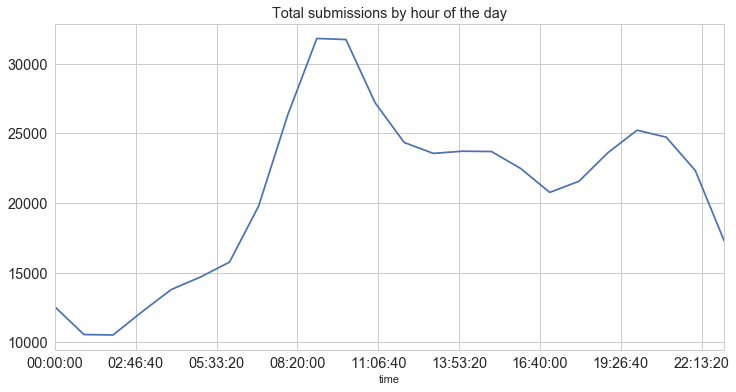

In [181]:
# hourly submissions pattern
hourly = temp.resample('H').count()
hourly.iloc[:, 0].groupby(hourly.index.time).sum().plot()
plt.title('Total submissions by hour of the day')

* Seems submissions are more common in the mornings and evenings (bimodal distribution). This is likely to be before/after work?

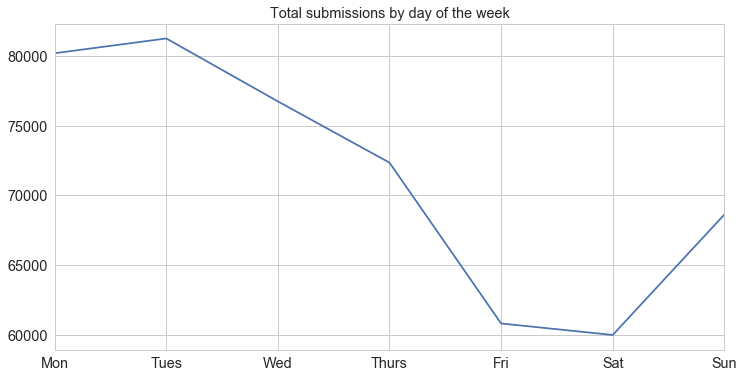

In [183]:
# weekly submissions pattern
weekly = temp.groupby(temp.index.dayofweek).count()
weekly.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
weekly.iloc[:, 0].plot()
plt.title('Total submissions by day of the week')

* Submissions die down on weekends, and peak on Tuesdays

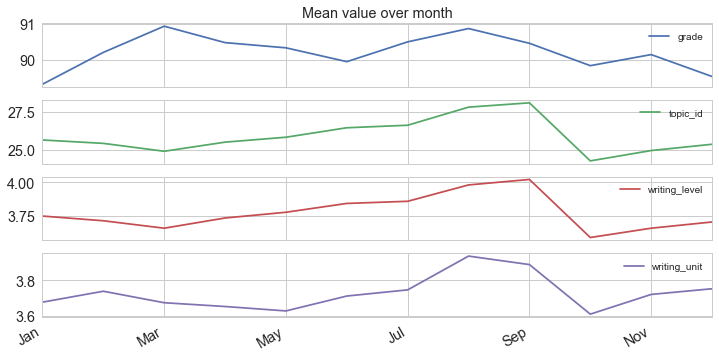

In [184]:
montly = temp.groupby(temp.index.month).mean()
montly.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax = montly.plot(subplots=True, sharex=True)
ax[0].set_title('Mean value over month')

* Difficult to see clear pattern wrt to time of the day, week-day or month

# Caveats for why I will only be using `text` to classify

At this point I should not the following before proceeding:

* I believe the aim of this exercise is to classify the levels given **only** the text from the student and none of the other data provided, i.e. drop `[date', 'grade', 'topic_id', 'topic_text', 'writing_id', 'writing_unit']`


* I believe this is the case because we saw that `topic_id` is pretty much representing the `writing_level`, so using this as a feature for the model would be 'cheating' and getting very high score


* In any case, the other variables, other than `grade` don't seem to be useful for prediction as there's no student `id` or the like to follow the progression of the student and build features based on that


* <span style="color:red">Because of this and given the short time for this exercise, I will proceed to only use the text for classification and no other input.</span> If there's time, I will try to test the impact of `grade` as a feature on the model score

# Target Engineering 

At this point I will proceed already to add the alternative target, which is the writing level `group`, given the provided CEFR mapping:

* Levels 1-3 = Group A1
* Levels 4-6 = Group A2
* Levels 7-9 = Group B1
* Levels 10-12 = Group B2
* Levels 13-15 = Group C1
* Levels 16 = Group C2

As there are 16 writing levels to predict and large class imbalance in the data, we expect this grouping to be better for classification.


In [136]:
df['group'] = pd.cut(df['writing_level'], bins=[0, 3, 6, 9, 12, 15, 16], labels=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
df[['writing_level', 'group']].sample(10)

,writing_level,group
2759,8,B1
6144,1,A1
8223,3,A1
6113,1,A1
1183,5,A2
4961,4,A2
5440,4,A2
5241,8,B1
512,5,A2
9867,10,B2


In [137]:
# df['group_id'] = pd.cut(df['writing_level'], bins=[0, 3, 6, 9, 12, 15, 16], labels=np.arange(1, 7))
# # Put as int instead of cat to get corr
# df['group_id'] = df['group_id'].astype(int)

# Text Feature Engineering

We focus then only on the `text` column and build features from this, to classify the target `writing_level`.

Ideally we would want featues covering the following subgroups:

* **Length** - e.g. length of sentences, number of tokens, chars, etc
* **Lexical** - incidence of words beloging to the Kelly list categorisation for A1-C2 words
* **Syntactic** - dependency arcs
* **Semantic** - senses
* **Morphological** - incidence of POS tags and sequences

<span style="color:red">Given the short time for this assigment, I was only able to cover length and lexical features to some extent, but the scores weren't great.</span>

### Slicing the data

To run things faster during testing, I reduced the dataset to the first 10k rows via this helper function which saves the `df` as a pickle for easy access after:

In [18]:
# prepare_and_save_pickle(10000, '10k.p')

In prepare_and_save_pickle... took:
Run time: 0h:0m:11s


In [12]:
df = open_pickle('data/10k.p')
df.head()

,idx,date,grade,text,topic_id,topic_text,writing_id,writing_level,writing_unit
0,0,2011-03-20 12:44:16.790,90,"\n After some time, the affection between...",41,Writing a movie plot,1,6,1
1,1,2011-03-26 09:31:35.133,90,\n An e-ticket is a provement that you bo...,42,Filling in an arrival card,2,6,2
2,2,2011-04-03 04:16:16.137,86,\n From:xxx@1234.com To:Herman xxx@1234.c...,43,Creating an office dress code,3,6,3
3,3,2011-03-23 23:53:12.710,87,"\n Hi Anna ,How are you . My name's Jayla...",1,Introducing yourself by email,4,1,1
4,4,2011-03-25 03:13:50.393,95,"\n Dear Ms Thomas, There are thirty pens ...",2,Taking inventory in the office,5,1,2


## CTextFeatures class

To build the text features, I created a class to make this easier and avoid recalculations. The full code can be found in `text_classifier.py`. 

The main dependencies are `nltk` and an external dictionary `lex_db` containing the Kelly list of words and CEFR levels (more later). It has the following structure:

```python
class CTextFeatures:

    def __init__(self, text): ...
        
    def tokenize(self): ...

    def get_features(self, lex_db=None, lmtzr=None): ...

    def get_lexical_features(self, lex_db, lmtzr=None): ...

    def clean_text(self): ...

```

Now I will demo the class with one example.

In [23]:
text = df.loc[2, 'text']
text

"\n      From:xxx@1234.com To:Herman xxx@1234.com Date:Friday,Nov25,2009 10:00AM Dear Herman Walpool, I am very glad to accept and successfully completed the task. According to your request, I drew up the company's dress code, the concrete content as follows: Men can only wear a suit and tie, the color of a suit must be blue and black.You can't wear jack and jeans and wear a hat and slippers. Women can wear a suit, the color of a suit must be white and blue. You can't wear skirts and tight clothes. Jewellery can't be allowed. All the dress fabrics pfefer cotton to silk or nylon Yours truly, Daniel\n    "

### clean_text

This method helps to clean the text to a basic level as per the comments below. Note there was no time to investigate the effect of this on the score, nor its validity.

```python

def clean_text(self):
    # replace very spefific email format found in one entry.
    self.text = re.sub('From:[A-Za-z0-9]+@[A-Za-z0-9]+.com ', ' ', self.text)
    self.text = re.sub('To:[A-Za-z0-9 ]+@[A-Za-z0-9]+.com ', ' ', self.text)
    self.text = re.sub('Date:[A-Za-z0-9 ,]+:[0-9]+[AP]M ', ' ', self.text)

    # normalise punctuation to just .
    punctuation_dic = {",": " ",  ### REMOVES ALL COMMAS
                       ";": " ",  ### REMOVES ALL Semi colons
                       ":": " ",  ### removes semicolons
                       "!": ".",  ### converts ! to .
                       "?": ".",  ### converts ? to .
                       }
    for entry in punctuation_dic:
        self.text = self.text.replace(entry, punctuation_dic[entry])

    # remove multiple .
    self.text = re.sub('\.+', '.', self.text)

    # add spaces after punctuation, remove repeated spaces, remove spaces before punctuation.
    self.text = self.text.replace('.', '. ')
    self.text = re.sub(' +', ' ', self.text)
    self.text = self.text.replace(' .', '.')

    # reduce hidden information '#' to just one symbol
    self.text = self.text.replace('# #', '#')
    self.text = re.sub('#+', '#', self.text)

    # replace quotation character with proper symbol in text
    self.text = self.text.replace('&quot;', "'")

    # replace newline character
    self.text = self.text.replace('\n', '')

    # remove leading and trailing white space of entire text block
    self.text = self.text.lstrip().rstrip()

    # ### normalise to lowercase ?????????????????????????
    self.text = self.text.lower()

    return self.text
```

In [24]:
text

"\n      From:xxx@1234.com To:Herman xxx@1234.com Date:Friday,Nov25,2009 10:00AM Dear Herman Walpool, I am very glad to accept and successfully completed the task. According to your request, I drew up the company's dress code, the concrete content as follows: Men can only wear a suit and tie, the color of a suit must be blue and black.You can't wear jack and jeans and wear a hat and slippers. Women can wear a suit, the color of a suit must be white and blue. You can't wear skirts and tight clothes. Jewellery can't be allowed. All the dress fabrics pfefer cotton to silk or nylon Yours truly, Daniel\n    "

In [36]:
tf = CTextFeatures(text)
tf.clean_text()
tf.text

"dear herman walpool i am very glad to accept and successfully completed the task. according to your request i drew up the company's dress code the concrete content as follows men can only wear a suit and tie the color of a suit must be blue and black. you can't wear jack and jeans and wear a hat and slippers. women can wear a suit the color of a suit must be white and blue. you can't wear skirts and tight clothes. jewellery can't be allowed. all the dress fabrics pfefer cotton to silk or nylon yours truly daniel"

### get_features

This function calculates all the features (both length-based and lexical):

* Starts by calling `tokenize` to **tokenize** the text unsing nltk's tokenizer:

```python
    def tokenize(self):
        self.tokenizedd = True
        self.tokens = nltk.word_tokenize(self.text)  # already normalised to lower case if used self.clean_text
        self.ntokens = len(self.tokens)
        self.tokens_len = [len(x) for x in self.tokens]  # use isalpha to ignore punctuation?
        self.sent_tokens = nltk.sent_tokenize(self.text)
        self.nsent = len(self.sent_tokens)
        self.sen_len = [len(x) for x in self.sent_tokens]
```

* It then gets the **length-based features**:

```python
        self.features = {
            # Length-based
            'nchars': self.nchars,
            'ntokens': self.ntokens,
            'nsent': self.nsent,
            'lexical_diversity': len(set(self.tokens)) / self.ntokens,  # number of distinct words wrt the total number of words
            'avg_sentence_length': np.mean(self.sen_len),
            # 'sentence_length_by_tokens': np.mean(self.sen_len) / self.ntokens,
            # 'sentence_length_by_chars': np.mean(self.sen_len) / self.nchars,
            'avg_token_length': np.mean(self.tokens_len),
            'nlongwords': len([x for x in self.tokens_len if x > 10]),
            'avg_tokens_per_sent': self.ntokens / self.nsent,  # could be biased by stop-words?
        }

```

* It then gets the **lexical features**, which is a lot more complicated as we need to first get the **POS** (Parts of Speech) tags, and then lemmatize the words before we can look them up in the Kelly list. As you can see, it gets the Kelly list (`lex_db`) and an `nltk` Lemmatizer as inputs:

```python

   def get_lexical_features(self, lex_db, lmtzr):
   
       ...
       ...
       
        # We need POS Tagging before word lemmatization if not already done to get grammar features
        if self.pos_tags is None:
            self.pos_tags = nltk.pos_tag(self.tokens)  # note must use tokens not types to detect correct POS
        # ensure no punctuation included
        self.lemmas = [(lmtzr(x[0], get_wordnet_pos(x[1])), x[1]) for x in self.pos_tags if x[0].isalpha()]

        self.level_counts = {'A1': 0,
                             'A2': 0,
                             'B1': 0,
                             'B2': 0,
                             'C1': 0,
                             'C2': 0,
                             'Unknown': 0
                             }
       ...
       ...

        for t in self.lemmas:
            word = t[0]
            pos_tag = t[1]
            try:
                # Look for word in Kelly list
                d = lex_db[word]
                if len(d) > 1:
                    # Look for right level depending on word POS tag
                    level = d[mappings[pos_tag]]
                else:
                    level = list(d.values())[0]
                # print(word, level, pos_tag)
                self.level_counts[level] += 1
            except KeyError:
                self.level_counts['Unknown'] += 1
                # print('{} failed!!!! ---> {}'.format(word, pos_tag))
                pass
        # Normalise to incidence scores (per total tokens)
        self.level_inc = {k + '_inc': v / self.ntokens for k, v in self.level_counts.items()}
        return self.level_inc
       
```

### get_lex_db

This is a helper function to get the Kelly list csv into dictionary format:

In [29]:
lex_db = get_lex_db()

In [31]:
len(lex_db)

6760

As example, let's look up for the word `after`:

In [30]:
lex_db['after']

{'adverb': 'C2', 'preposition': 'A1'}

We see it has different levels assigned depending on whether it is used as a preposition or as an adverb.

### Back to get_features

Let's demo this now that we have `lex_db`:

In [37]:
tf.get_features(lex_db)

{'A1_inc': 0.5045871559633027,
 'A2_inc': 0.10091743119266056,
 'B1_inc': 0.07339449541284404,
 'B2_inc': 0.045871559633027525,
 'C1_inc': 0.01834862385321101,
 'C2_inc': 0.01834862385321101,
 'Unknown_inc': 0.14678899082568808,
 'avg_sentence_length': 73.0,
 'avg_token_length': 3.8440366972477062,
 'avg_tokens_per_sent': 15.571428571428571,
 'lexical_diversity': 0.5963302752293578,
 'nchars': 607,
 'nlongwords': 1,
 'nsent': 7,
 'ntokens': 109}

## Getting features for full df

For this we use this helper function, which uses a `lambda` function to apply the class methods to every row:

```python
def build_features(df):
    # Get text features
    start_time = time.time()

    print('Cleaning text...')
    df['text_cleaned'] = df['text'].apply(lambda x: pd.Series(CTextFeatures(x).clean_text()))

    print('Building features...')
    lmtzr = nltk.WordNetLemmatizer().lemmatize
    lex_db = get_lex_db()
    df = df.join(df['text_cleaned'].apply(lambda x: pd.Series(CTextFeatures(x).get_features(lex_db, lmtzr))))
    names = list((CTextFeatures(df.loc[0, 'text_cleaned']).get_features(lex_db, lmtzr)).keys())
    print_runtime(start_time)
    return df, names
```

In [39]:
df, derived_features = build_features(df)
target = 'writing_level'

Cleaning text...
Building features...
Run time: 0h:1m:10s


Which then looks like this:

In [47]:
df[[target] + derived_features].head()

,writing_level,nchars,ntokens,nsent,lexical_diversity,avg_sentence_length,avg_token_length,nlongwords,avg_tokens_per_sent,A1_inc,A2_inc,B1_inc,B2_inc,C1_inc,C2_inc,Unknown_inc
0,6,328.0,65.0,6.0,0.707692,53.833333,4.169231,2.0,10.833333,0.569231,0.046154,0.092308,0.000000,0.000000,0.015385,0.169231
1,6,411.0,88.0,6.0,0.636364,67.666667,3.852273,0.0,14.666667,0.579545,0.022727,0.068182,0.000000,0.011364,0.022727,0.136364
2,6,517.0,109.0,7.0,0.596330,73.000000,3.844037,1.0,15.571429,0.504587,0.100917,0.073394,0.045872,0.018349,0.018349,0.146789
3,1,63.0,17.0,3.0,0.823529,20.333333,3.000000,0.0,5.666667,0.470588,0.058824,0.058824,0.000000,0.000000,0.000000,0.117647
4,1,211.0,38.0,3.0,0.736842,69.666667,4.657895,0.0,12.666667,0.447368,0.236842,0.000000,0.078947,0.000000,0.026316,0.131579


# Feature selection

i.e. which are the most important predictors?

## Using correlations 

Let's look first at the correlations with the target:

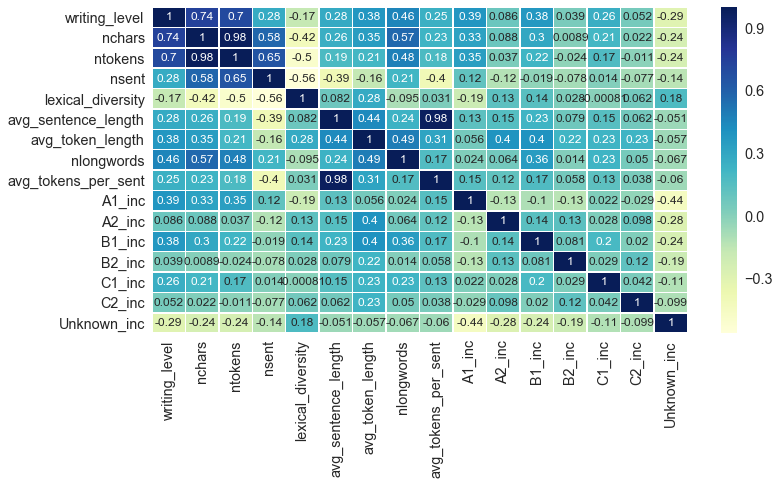

In [133]:
target = 'writing_level'
corr = df[[target] + derived_features].corr()
sns.heatmap(corr, annot=True, linewidths=.5, cmap="YlGnBu")

* With this heatmap it becomes clear the **multicollinearity** is an issue, e.g. `nchars` and `ntokens` highly correlated between them, but also with the target (`writing_level`). This pattern appears for many other vars, e.g. `avg_tokens_per_sent` vs `avg_sentence_length`. <span style="color:red">This is something that is important to handle via a feature selection procedure.</span>

What about the high correlation between level and `nchars` or `ntokens`? The below box plot shows there is certainly a positive correlation, although there are quite a few outliers, espcially in the higher levels

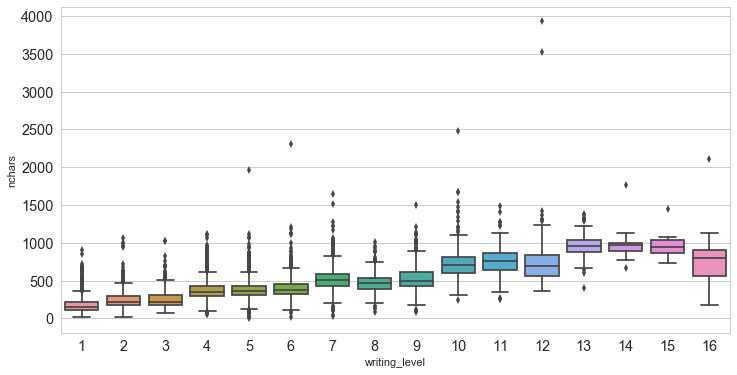

In [79]:
sns.boxplot(x='writing_level', y='nchars', data=df)

# Alternative using pandas but there's a bug with now showing outliers
# df.pivot(columns='writing_level', values='nchars').plot(kind='box')

Difficult to see if `lexical_diversity` is negatively correlated to the target, but this could be influenced by stop-words...

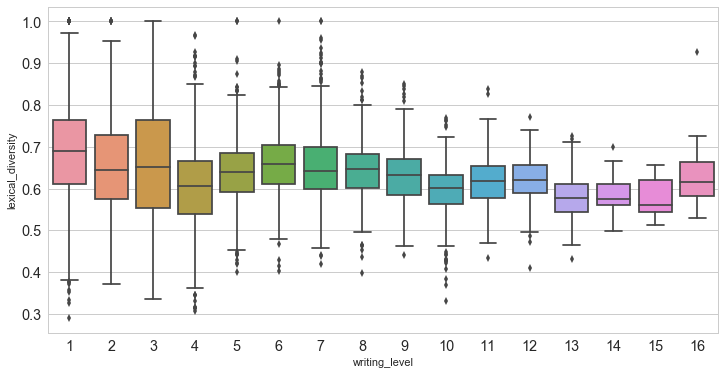

In [81]:
sns.boxplot(x='writing_level', y='lexical_diversity', data=df)

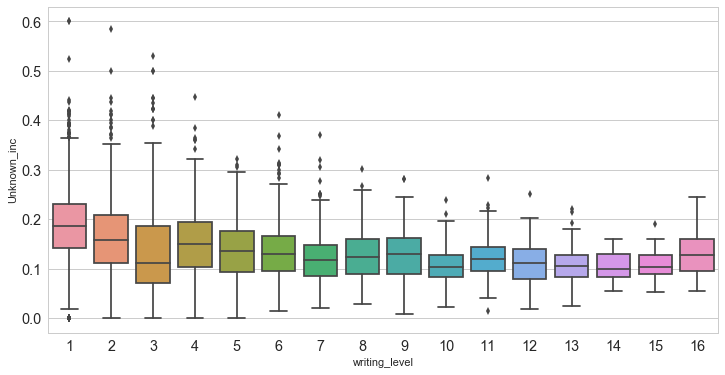

In [134]:
sns.boxplot(x='writing_level', y='Unknown_inc', data=df)

* The negative corr with `Unknown_inc` could be due to higher number of typos/spelling mistakes in the lower levels? However, the large number of outliers in the data, makes it hard to conclude this...

We could do a simple feature selection by eliminating those that have high collinearity, but instead we will use `sklearn`'s `SelectFromModel`

## Using SelectFromModel to select features

In [135]:
derived_features

['nchars',
 'ntokens',
 'nsent',
 'lexical_diversity',
 'avg_sentence_length',
 'avg_token_length',
 'nlongwords',
 'avg_tokens_per_sent',
 'A1_inc',
 'A2_inc',
 'B1_inc',
 'B2_inc',
 'C1_inc',
 'C2_inc',
 'Unknown_inc']

#### Feature selection using L2 regularisation

This allows for small, although not zero, coefficients.

In [201]:
# Feature selection using L2 regularisation on levels with SVC
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

target = 'writing_level'

X = df[derived_features]
y = df[target]

lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X.columns[model.get_support()]

Index(['lexical_diversity', 'avg_token_length', 'A1_inc', 'A2_inc', 'B1_inc',
       'Unknown_inc'],
      dtype='object')

In [153]:
# Feature selection using L2 regularisation on levels with logit reg
from sklearn.linear_model import LogisticRegression

target = 'writing_level'

X = df[derived_features]
y = df[target]

logit = LogisticRegression(penalty="l2").fit(X, y)
model = SelectFromModel(logit, prefit=True)
X.columns[model.get_support()]

Index(['lexical_diversity', 'A1_inc', 'A2_inc', 'B1_inc', 'B2_inc',
       'Unknown_inc'],
      dtype='object')

#### Feature selection using L1 regularisation

This sets some coefficients to zero

In [142]:
# Feature selection using L1 regularisation on levels with SVC
target = 'writing_level'

X = df[derived_features]
y = df[target]

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X.columns[model.get_support()]

Index(['nchars', 'ntokens', 'nsent', 'lexical_diversity',
       'avg_sentence_length', 'avg_token_length', 'nlongwords',
       'avg_tokens_per_sent', 'A1_inc'],
      dtype='object')

In [148]:
# Feature selection using L1 regularisation on levels with logit reg
target = 'writing_level'

X = df[derived_features]
y = df[target]

logit = LogisticRegression(penalty="l1").fit(X, y)
model = SelectFromModel(logit, prefit=True)
X.columns[model.get_support()]

Index(['nchars', 'ntokens', 'nsent', 'lexical_diversity',
       'avg_sentence_length', 'avg_token_length', 'nlongwords',
       'avg_tokens_per_sent', 'A1_inc', 'A2_inc', 'B1_inc', 'B2_inc', 'C1_inc',
       'C2_inc', 'Unknown_inc'],
      dtype='object')

#### Feature selection using Random Forests


(-1, 15)

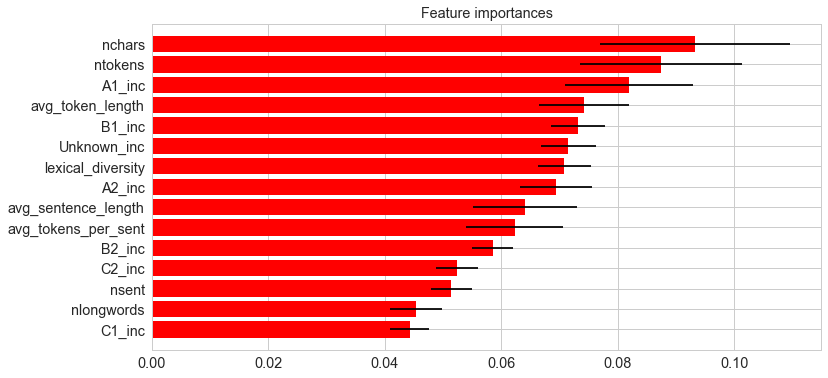

In [218]:
from sklearn.ensemble import ExtraTreesClassifier

X = df[derived_features]
y = df[target]

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), [derived_features[i] for i in indices])
plt.ylim([-1, X.shape[1]])

### Conclusions on Feature importance

* Depending on the method used, once gets different results
* L2 regularisation using SVC and LogisticRegression gave similar results
* Would need to do additional work to understand this further


# Selecting the model

Given the limited time, the model selection step also was rather rushed. For this, different 'pipelines' functions were added to `text_classifier.py` to run different models with cross-validation as follows:

```python
def run_simple(X, y, model):
    print('Running model... took:')
    start_time = time.time()
    # split the data with 50% in each set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.8)
    # fit the model on one set of data
    model.fit(X_train, y_train)
    # evaluate the model on the second set of data
    y_test_model = model.predict(X_test)
    print_runtime(start_time)
    print(accuracy_score(y_test, y_test_model))


def cross_val_pipeline(X, y, model):
    # Cross-validation
    print('Running pipeline... took:')
    start_time = time.time()
    pipeline = make_pipeline(model)
    scores = cross_val_score(pipeline, X, y, cv=4)  # investigate how to speed up
    print_runtime(start_time)
    print('scores={}\nmean={:.4f}'.format(scores, np.mean(scores)))


def grid_search_pipeline(X, y, models):
    # Gridsearch with CV
    print('Running pipeline... took:')
    start_time = time.time()
    pipe = Pipeline([('clf', SVC())])
    param_grid = dict(clf=models)
    grid_search = GridSearchCV(pipe, param_grid=param_grid)  # investigate how to speed up
    grid_search.fit(X, y)
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    print_runtime(start_time)
    return grid_search

```

Here we only present the results after running different scenarios.

In [226]:
size = 10000
pickle_name = '{}k.p'.format(int(size / 1000))

df = open_pickle('data/{}'.format(pickle_name))

df, derived_features = build_features(df)

# Alternative target
df['group'] = pd.cut(df['writing_level'], bins=[0, 3, 6, 9, 12, 15, 16],
                     labels=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])

# Select only these to benchmark vs v2
features = ['ntokens',
            'nsent',
            'avg_tokens_per_sent',
            'lexical_diversity',
            'avg_token_length',
            'nlongwords',
            'nchars',
            'A1_inc',
            'A2_inc',
            'B1_inc',
            'B2_inc',
            'C1_inc',
            'C2_inc',
            #'n_spelling_mistakes',
            ]

X = df[features]
y = df['writing_level']  # switch for 'group' target

models = [SVC(random_state=0),
          LogisticRegression(random_state=0),
          RidgeClassifier(random_state=0),
          MLPClassifier(random_state=0),
          LinearSVC(random_state=0),
          DecisionTreeClassifier(random_state=0)]

model = models[-1]  # DecisionTreeClassifier

run_simple(X, y, model)

Cleaning text...
Building features... took:
Run time: 0h:1m:18s
Running model... took:
Run time: 0h:0m:0s
0.409


/Users/tsando/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### DecisionTreeClassifier

#### Levels as target

In [231]:
X = df[features]
y = df['writing_level']  # switch for 'group' target

model = DecisionTreeClassifier(random_state=0)

# split the data with 50% in each set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.8)

# fit the model on one set of data
model.fit(X_train, y_train)

# evaluate the model on the second set of data
y_test_model = model.predict(X_test)

print('accuracy={}'.format(accuracy_score(y_test, y_test_model)))

accuracy=0.409


/Users/tsando/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


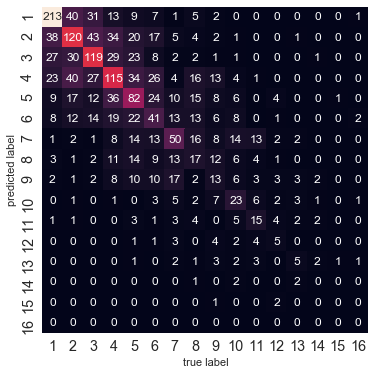

In [228]:
from sklearn.metrics import confusion_matrix

labels = np.sort(np.unique(y_test))
mat = confusion_matrix(y_test, y_test_model)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

#### Group as target

In [232]:
X = df[features]
y = df['group']  # switch for 'group' target

model = DecisionTreeClassifier(random_state=0)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.8)

# fit the model on one set of data
model.fit(X_train, y_train)

# evaluate the model on the second set of data
y_test_model = model.predict(X_test)

print('accuracy={}'.format(accuracy_score(y_test, y_test_model)))

accuracy=0.65


/Users/tsando/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


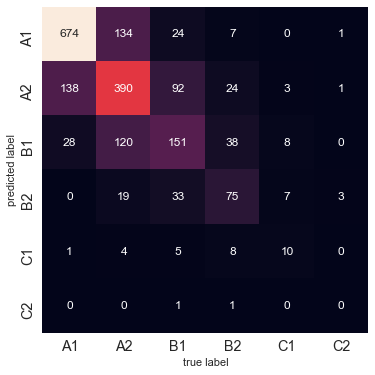

In [233]:
from sklearn.metrics import confusion_matrix

labels = np.sort(np.unique(y_test))
mat = confusion_matrix(y_test, y_test_model)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

* So as expected, the model performs better when the target is `group` than `writing_level`


* For the higher levels/groups, the prediction power decreases, as we have a lot more false positives and false negatives

# Summary of results

* Models were chosen based on literature found to address similar classification problems
* Surprisingly Multinomial Naive Bayes model wasn't very good for this case, as it often is for text classification, so it was excluded
* Performance increases with train data size
* Best model was MLPClassifier with 70% accuracy using 10-fold CV and 100k for training

 | | | |**16 levels Score**| |**6 groups Score**| 
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
Sample size|Pickle time|Feature building time|Model|80/20|CrossValidation (10-fold)|80/20|CrossValidation (10-fold)
10k|6s|1m11s|SVC|0.3051| |0.6272| 
10k| | |LogisticRegression|0.3624| |0.6275| 
10k| | |RidgeClassifier|0.3309| |0.5771| 
10k| | |MLPClassifier|0.3251| | <font color='red'>0.6465</font>| 
10k| | |LinearSVC|0.2503| |0.5205| 
10k| | |DecisionTreeClassifier| <font color='red'>0.4000</font>| |0.6385| 
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|-----:
100k|9s|12m9s|SVC|0.3940| |-| 
100k| | |LogisticRegression|0.4162| |0.6569| 
100k| | |RidgeClassifier|0.3670| |0.6037| 
100k| | |MLPClassifier| <font color='red'>0.4739</font>|0.4908| <font color='red'>0.7179</font>|0.7068
100k| | |LinearSVC|0.2538| |-| 
100k| | |DecisionTreeClassifier|0.4734| |0.6992| 

# Unsupervised classification with k-means clustering

Using the first 100k rows features defined above, we get the below results:

In [248]:
np.unique(y_kmeans)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [244]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [345]:
# Calculate score
from scipy.stats import mode

labels = np.zeros_like(y_kmeans, dtype='string_')
labels = np.chararray(labels.shape, itemsize=5)

for i in range(len(np.unique(y_kmeans))):
    print(i)
    mask = (y_kmeans == i)
    labels[mask] = mode(y[mask])[0]

labels = [str(l).split("'")[1] for l in labels]
print('accuracy={}'.format(accuracy_score(y, labels)))

0
1
2
3
4
5
accuracy=0.6347


/Users/tsando/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


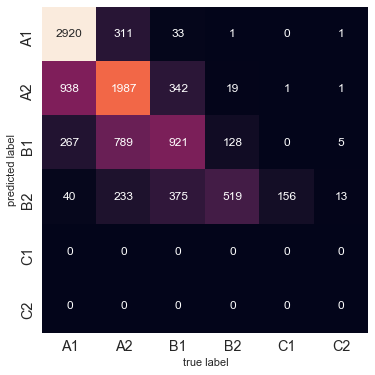

In [347]:
from sklearn.metrics import confusion_matrix

labels2 = np.sort(np.unique(y_test))
mat = confusion_matrix(y, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels2,
            yticklabels=labels2)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Future work


### In hindsight ...

Spent too much time on EDA and extracting the data into csv, sacrificing therefore on feature eng and model optimisation... Here are some things I would like to investigate:


### Data preproc / Feature Eng

* Remove outliers

* effect from stop words on features and model scores

* Cleaning up data better

* Feature Scaling: did not scale the data - must understand effects from this on models, e.g. use `preprocessing.StandardScaler()`

* Get stats based on full sample, e.g. difficult word (least frequent in whole sample), sample sentence length average, etc

* Using grade as predictor

* Grammatical features, e.g. 
    * you can have word n-grams, character n-grams, syntax trees, part-of-speech tags, n-grams of part of speech tags etc --> nltk
    * basic features: POS-tags

            text = word_tokenize(“And now for something completely different”)
            nltk.pos_tag(text)
            [(‘And’, ‘CC’), (‘now’, ‘RB’), (‘for’, ‘IN’), (‘something’, ‘NN’),
            (‘completely’, ‘RB’), (‘different’, ‘JJ’)]

    so each word is mapped to a POS tag
    from there you can extract POS sequences, for example in the example above it would be:

            CC, RB, IN, NN, RB, JJ

    * and from there then, (CC,RB), (RB,IN), (IN,NN), (NN,RB), (RB,JJ),  (JJ,<End>) your POS 2-grams. this is simple to do in sklearn: `CountVectorizer( ngram_range = (1,2) , … )`. 
    `fit_transform( )` on a `CountVectorizer` object will give you back a matrix of occurences
    which then you can concat with the rest of your features and feed it to your classifier

* Spelling mistakes


### Model Optimisation / Improving scores

* Running on full dataset, e.g. by using batching and `njob` from sklearn or parallel proc.
* optimising model selection based on recall (true positives) instead of accuracy given class imbalance
* optimising model parameters, e.g. via `sklearn GridSearch`
* validation and learning curves to find optimal model

### Nice to have

* Further refactor code and class


### Other


* Would have been useful if we had a `user_id` as part of the data, so that a 'progression' metric could have been used as a feature of the model (students who have completed most units in a level are more likely to pass to the next level)

* Not checking whether the text written by student always addresses the topic

* Putting into class instead of functions

* Typos / spelling mistakes

* People, places names
